<a href="https://colab.research.google.com/github/Aanvetha/Aanvetha/blob/main/Sepsisdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start

In [ ]:
!pip install awscli --upgrade --quiet

In [134]:
!mkdir -p /content/drive/MyDrive/physionet2019/
!aws s3 sync --no-sign-request s3://physionet-open/challenge-2019/1.0.0/training/ /content/drive/MyDrive/physionet2019/training/


Streaming output truncated to the last 5000 lines.
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115000.psv to drive/MyDrive/physionet2019/training/training_setB/p115000.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115002.psv to drive/MyDrive/physionet2019/training/training_setB/p115002.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115003.psv to drive/MyDrive/physionet2019/training/training_setB/p115003.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115004.psv to drive/MyDrive/physionet2019/training/training_setB/p115004.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115006.psv to drive/MyDrive/physionet2019/training/training_setB/p115006.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115005.psv to drive/MyDrive/physionet2019/training/training_setB/p115005.psv
download: s3://physionet-open/challen

In [136]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

In [137]:
data_path = "/content/drive/MyDrive/physionet2019/training/"

In [ ]:
def load_physionet_data(paths):
    data = []
    for path in paths:
        files = [f for f in os.listdir(path) if f.endswith(".psv")]
        for f in files[:1000]:  # limit to 1000 for now
            df = pd.read_csv(os.path.join(path, f), sep="|")
            df["patient_id"] = f.replace(".psv", "")
            data.append(df)
    return pd.concat(data, ignore_index=True)

data_paths = [
    "/content/drive/MyDrive/physionet2019/training_setA",
    "/content/drive/MyDrive/physionet2019/training_setB"
]

train_df = load_physionet_data(data_paths)
train_df.head()


to know the structure

In [ ]:
print("Shape of dataset:", train_df.shape)
print("\nColumn types:\n", train_df.dtypes)
print("\nNumber of unique patients:", train_df["patient_id"].nunique())
train_df.info()

EDA

Missing Values Analysis

In [ ]:
missing = train_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

In [ ]:
missing = train_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percentage})
missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
Bilirubin_direct,76689,99.830771
Fibrinogen,76320,99.350421
TroponinI,76075,99.031490
Bilirubin_total,75621,98.440490
Alkalinephos,75499,98.281675
AST,75485,98.263450
Lactate,74724,97.272810
PTT,74554,97.051511
EtCO2,74390,96.838022
SaO2,74282,96.697432


Distribution

<Axes: xlabel='HR', ylabel='Density'>

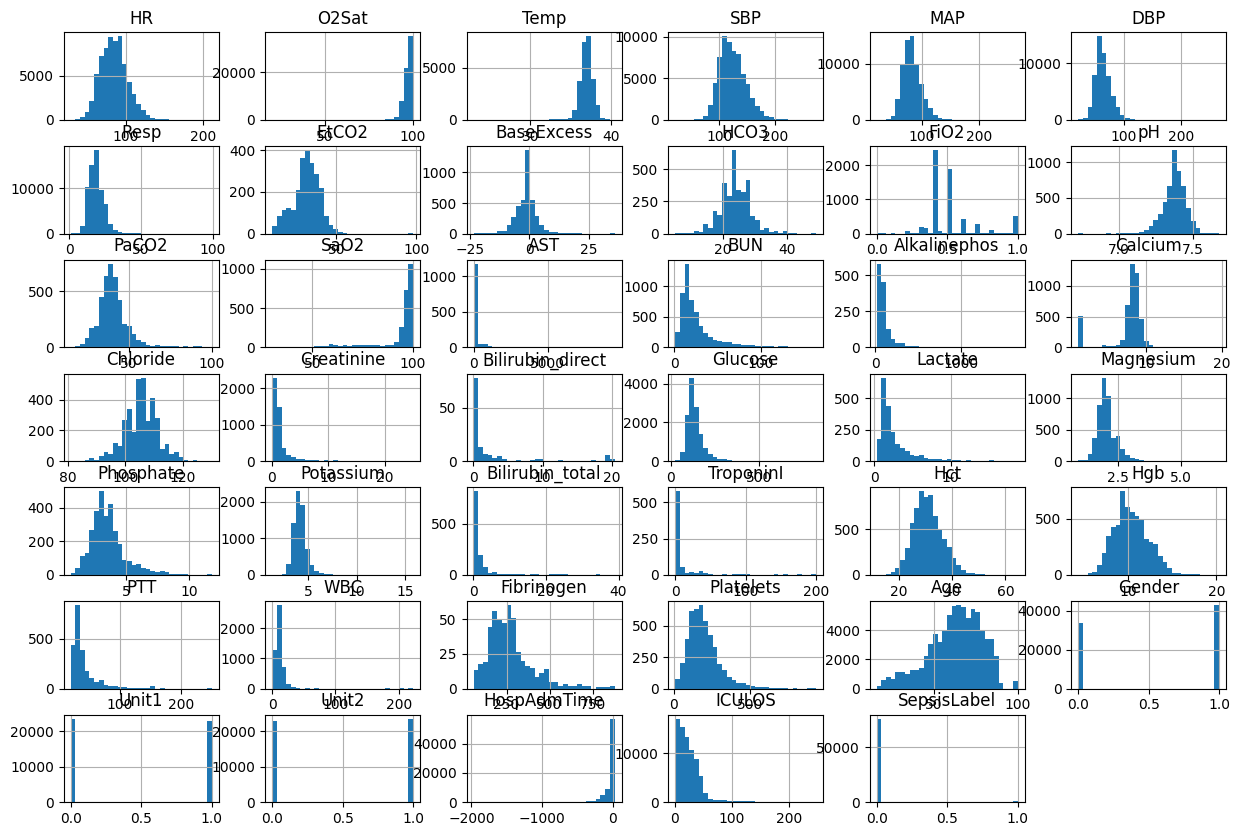

In [ ]:
train_df.hist(figsize=(15, 10), bins=30)
sns.kdeplot(train_df['HR'].dropna())

<Axes: title={'center': 'Vitals over time'}, xlabel='ICULOS'>

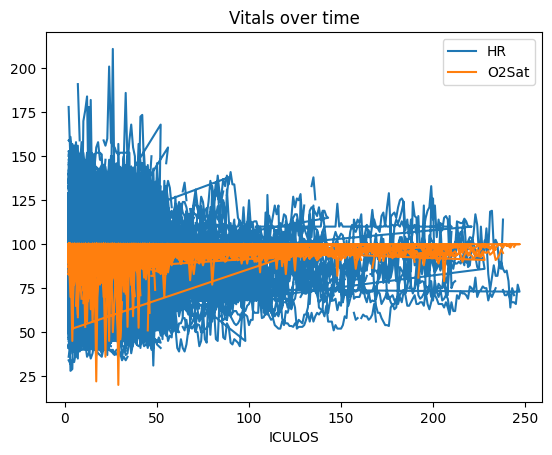

In [ ]:
train_df[['ICULOS', 'HR', 'O2Sat']].plot(x='ICULOS', title='Vitals over time')

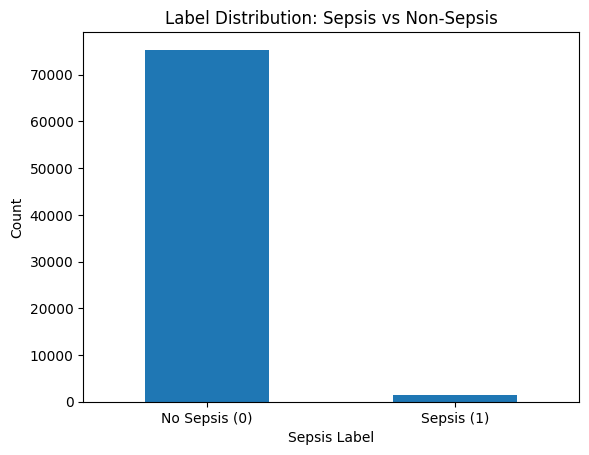

In [ ]:
train_df['SepsisLabel'].value_counts().plot(kind='bar')
plt.title('Label Distribution: Sepsis vs Non-Sepsis')
plt.xlabel('Sepsis Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Sepsis (0)', 'Sepsis (1)'], rotation=0)
plt.show()


Correlation analysis


1. -ve (red)
2.  +ve REd
3. no correlation(white

<Axes: >

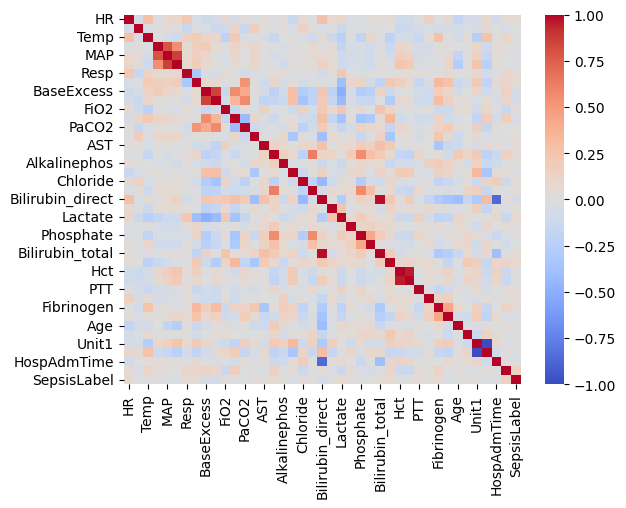

In [ ]:
corr = train_df.drop(columns=['patient_id']).corr()
sns.heatmap(corr, cmap='coolwarm')

In [ ]:
def load_physionet_data(paths):
    data = []
    for path in paths:
        files = [f for f in os.listdir(path) if f.endswith(".psv")]

for one patient missing values

In [ ]:
# Sort first
train_df = train_df.sort_values(by=['patient_id', 'ICULOS'])

# Fill missing values forward and backward per patient
train_df = train_df.groupby('patient_id').apply(lambda x: x.ffill().bfill()).reset_index(drop=True)

# Optional: drop rows with any remaining missing values
train_df = train_df.dropna()


KeyError: 'patient_id'

In [ ]:
train_df = train_df.sort_values(by='ICULOS')
train_df = train_df.ffill().bfill()


Normalization

In [ ]:
print("train_df shape:", train_df.shape)
print("feature_cols:", feature_cols.tolist())
print("Subset shape:", train_df[feature_cols].shape)


train_df shape: (0, 41)
feature_cols: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']
Subset shape: (0, 39)


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Select features
feature_cols = train_df.select_dtypes(include='number').columns.drop(['SepsisLabel', 'ICULOS'], errors='ignore')

# Step 2: Only scale if there is data
if not train_df.empty and not train_df[feature_cols].empty:
    scaler = StandardScaler()
    train_df[feature_cols] = pd.DataFrame(
        scaler.fit_transform(train_df[feature_cols]),
        columns=feature_cols,
        index=train_df.index
    )
    print("Scaling applied.")
else:
    print("train_df is empty or has no feature columns to scale.")


train_df is empty or has no feature columns to scale.


In [ ]:
print("train_df shape:", train_df.shape)
print("train_df columns:", train_df.columns.tolist())

# Check if feature_cols was selected properly
print("Selected feature columns:", feature_cols.tolist())

# Check if numeric data exists
print("train_df[feature_cols] shape:", train_df[feature_cols].shape)


train_df shape: (0, 41)
train_df columns: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
Selected feature columns: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']
train_df[feature_cols] shape: (0, 39)
